#Building a song recommender

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import sklearn, pandas
import numpy as np

#Load music data

In [5]:
song_data = pandas.read_csv('/content/drive/MyDrive/Practice Notebook/Song Recommender/song_data.csv')

#Explore data

Music data shows how many times a user listened to a song, as well as the details of the song.

In [6]:
song_data.head()

,user_id,song_id,listen_count,title,artist,song
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Jack Johnson,The Cove - Jack Johnson
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Paco De Lucia,Entre Dos Aguas - Paco De Lucia
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Kanye West,Stronger - Kanye West
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,Jack Johnson,Constellations - Jack Johnson
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,Foo Fighters,Learn To Fly - Foo Fighters


##Showing the most popular songs in the dataset

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

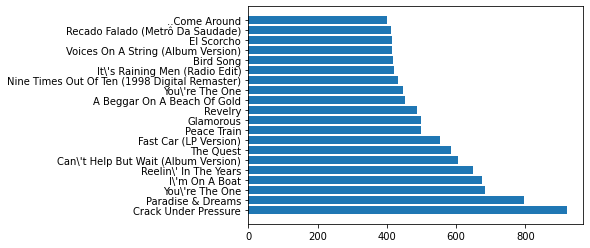

In [8]:
#song_data['song'].show()
# most listened time on ONE user
best_songs = song_data.sort_values('listen_count', ascending=False).head(20)
counter_labels = best_songs['title']
counts = best_songs['listen_count']
counter_pos = np.arange(20)
plt.barh(counter_pos, counts)
plt.yticks(counter_pos, counter_labels)
plt.show()

In [9]:
len(song_data)

1116609

##Count number of unique users in the dataset

In [10]:
users = song_data['user_id'].unique()

In [11]:
len(users)

66346

<b>Quiz: Who has the most listeners? Most listen count? Least listen count?<b>

#Create a song recommender

In [12]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(song_data, train_size=0.8, test_size=0.2, random_state=0)
print(len(train_data), len(test_data))
#train_data,test_data = song_data.random_split(.8,seed=0)

893287 223322


##Simple popularity-based recommender

In [13]:
popularity = pandas.DataFrame(song_data).groupby('song')['listen_count'].agg('sum').to_frame('total_listen_count')
popularity = popularity.sort_values('total_listen_count', ascending=False)

###Use the popularity model to make some predictions

A popularity model makes the same prediction for all users, so provides no personalization.

In [14]:
popularity.head(10)
#popularity_model.recommend(users=[users[0]])

,total_listen_count
song,
You\'re The One - Dwight Yoakam,40619
Undo - Björk,36059
Revelry - Kings Of Leon,30391
Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile) - Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner,21953
Sehr kosmisch - Harmonia,21646
Dog Days Are Over (Radio Edit) - Florence + The Machine,15889
Secrets - OneRepublic,14149
Ain\'t Misbehavin - Sam Cooke,14029
Invalid - Tub Ring,13701


In [15]:
#popularity_model.recommend(users=[users[1]])

##Build a song recommender with personalization

We now create a model that allows us to make personalized recommendations to each user. 

Be patient, the song-to-user mapping is very large, so calculation of similarity onto itself is expensive

In [16]:
# First, create data of songs listeners. We can use a customized word-count for this task. First, we group the data by the song
song_data_grouped = song_data.groupby("song")["user_id"].agg(lambda val: " ".join(val.values))
# song_data_grouped.head()
# Now we convert the ids using CountVectorizer.
from sklearn.feature_extraction.text import CountVectorizer
values = CountVectorizer(max_features=1000).fit_transform(song_data_grouped.values)
dense_values = values.todense()
print(dense_values.shape)
# Calculate songs similarity using Jaccard 
from scipy.spatial.distance import cdist
similarity = cdist(dense_values, dense_values, 'jaccard') # item x item
print(similarity.shape)

(9952, 1000)
(9952, 9952)


In [29]:
dense_values

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [17]:
# the similarity above is 0 for absolute match to 1 for no match. Let's use a random song:
random_song = 2010
print("Random song name: {:s}".format(song_data_grouped.index[random_song]))
# get the most similar, excluding the first (because obviously one song is most similar to itself)
def retrieve_similar_items(song_id, values_kept=20):
    return np.argsort(similarity[song_id])[1:1+values_kept]
similar_10 = retrieve_similar_items(random_song, values_kept=10)
print("List of 10 similar songs:\n{}".format("\n".join((song_data_grouped.index[similar_10]))))

Random song name: Disco Heaven - Lady GaGa
List of 10 similar songs:
Hope For The Hopeless - A Fine Frenzy
The Medallion Calls - Klaus Badelt
They Do_ They Don\'t - Jack Johnson
Anything But Ordinary - Avril Lavigne
City Of The Dead - The Clash
FANTASY - Mariah Carey
That\'s How You Like It - Beyoncé feat. Jay-Z
Ain\'t Talkin\'  \'Bout Love (Remastered Version) - Van Halen
Amsterdam - Coldplay
Mediocre Bad Guys - Jack Johnson


In [18]:
# Now, we build the recommender basing on the song similarity and the user's own listening history.
song_lookup_dict = {name: i for i, name in enumerate(song_data_grouped.index)}
def congregate_song(row, values_kept=20):
    songs_data = similarity[row["song"]]
    song_and_listen = songs_data * np.expand_dims(row["listen_count"], axis=1)
    song_and_listen = np.argsort(np.sum(song_and_listen, axis=0))
    #print(song_and_listen.shape)
    if(values_kept is not None and values_kept != 0):
        return song_and_listen[:values_kept]
    else:
        return song_and_listen

def recommend(users, song_number=20):
    # filter the data
    users_data_id = song_data["user_id"].isin(users)
    users_data = song_data.loc[users_data_id].groupby("user_id")["song", "listen_count"].agg({
        "song": lambda x: np.vectorize(song_lookup_dict.get)(x.values).tolist(),
        "listen_count": lambda x: x.values.tolist()
    })

    users_data["recommend"] = users_data.apply(lambda x: congregate_song(x, values_kept=song_number), axis=1)
    return users_data

def show_songs_list(users_data):
    #users_data.reindex(columns=["song", "listen_count"])
    for row in users_data.iterrows():
        print("User {:s}'s recommended songs:'\n{:s}".format(
            row[0], 
            "\n".join( (song_data_grouped.index[song_id] for song_id in row[-1]["recommend"]))
        ))
#recommend(users[:2])

In [30]:
song_lookup_dict.get

<function dict.get>

###Applying the personalized model to make song recommendations

As you can see, different users get different recommendations now.

In [19]:
show_songs_list(recommend(users=[users[0]]))

User b80344d063b5ccb3212f76538f3d9e43d87dca9e's recommended songs:'
Moonshine - Jack Johnson
Behind The Sea [Live In Chicago] - Panic At The Disco
I\'ll Be Missing You (Featuring Faith Evans & 112)(Album Version) - Puff Daddy
I?\'m A Steady Rollin? Man - Robert Johnson
Por La Noche - Mala Rodriguez
Apuesta Por El Rock \'N\' Roll - Héroes del Silencio
Ya No Sos Igual - 2 Minutos
Bigger Isn\'t Better - The String Cheese Incident
The Cove - Jack Johnson
Constellations - Jack Johnson
Holes To Heaven - Jack Johnson
Héroe De Leyenda - Héroes del Silencio
Love Song For No One - John Mayer
People Watching - Jack Johnson
Ghost Dream - Hymie\'s Basement
Neon - John Mayer
Danse Pour Moi - M. Pokora
Flashdance... What A Feeling - Irene Cara
B.I.G. (Interlude)(Amended Version) - The Notorious B.I.G.
The Message/ Outro - Dr. Dre / Thomas Chong / Mary J. Blige / Rell


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()


In [20]:
show_songs_list(recommend(users=[users[1]]))

User 85c1f87fea955d09b4bec2e36aee110927aedf9a's recommended songs:'
The Best of Times - Sage Francis
Side To Side (Featuring Lateef & Pigeon John) (Album Version) - Blackalicious
Big Munny - Swizz Beatz
Southside - Common / Kanye West
It\'s Me B*#@hes - Swizz Beatz
You Know Your Boy Did That - Swizz Beatz
Work (Explicit) - Gang Starr
Diamonds From Sierra Leone - Kanye West / Jay-Z
Never Let Me Down - Kanye West / Jay-Z / J. Ivy
The Food - Common
Ringing Bells - Masta Killa
Bring The Noize - DMX
In Between The Years - Ulrich Schnauss
Down And Out (Album Version) - The Academy Is...
Mutha\'uckas (Album Version) - Flight Of The Conchords
The Choice Is Yours - Black Sheep
Maxine - Traveling Wilburys
Is She Weird - Pixies
Kick In The Door (Soundtrack Version) (Explicit) - Notorious B.I.G.
Beloved Kitty and the Piercing Bolts of Amor - Ordo Rosarius Equilibrio


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()


###We can also apply the model to find similar songs to any song in the dataset

In [21]:
u2_similar_index = retrieve_similar_items(song_lookup_dict['With Or Without You - U2'], values_kept=5)
print("List of 5 similar songs:\n{}".format("\n".join(song_data_grouped.index[u2_similar_index])))

List of 5 similar songs:
Decisiones - Ruben Blades
What I Want - Dead Or Alive
You Are A Knife - Veto
Dead Man (Carry Me) - Jars Of Clay
A Kind Of Hope - Pilot Speed


In [22]:
bvsc_similar_index = retrieve_similar_items(song_lookup_dict['Chan Chan (Live) - Buena Vista Social Club'], values_kept=5)
print("List of 20 similar songs:\n{}".format("\n".join(song_data_grouped.index[bvsc_similar_index])))

List of 20 similar songs:
Amor de Loca Juventud - Buena Vista Social Club
Murmullo - Buena Vista Social Club
Shaman\'s Blues ( LP Version ) - The Doors
Until The Morning - Thievery Corporation
La Bayamesa - Buena Vista Social Club


#Quantitative comparison between the models

We now formally compare the popularity and the personalized models using precision-recall curves. This may take a while to be done. First of all, we trim the test data and create the functions to check if the songs listened by any users are predicted using our models.

In [23]:
# remove all users that have no data in the training set, just to make sure
sample_test_data = test_data.loc[test_data["user_id"].isin(train_data["user_id"])]
sample_test_data = sample_test_data.groupby("user_id")["song"].agg(
        lambda x: np.vectorize(song_lookup_dict.get)(x.values).tolist() #x.values.tolist() 
    )
#print(sample_test_data.iloc[0])
def recommend_popularity(user):
    return np.vectorize(song_lookup_dict.get)(popularity.index.values).to_list()

def recommend_personalized(user, song_number=1000):
    return recommend([user], song_number=song_number)["recommend"].to_list()[0]

Now we calculate the Precision/Recall values for a sample of first 1000 users. Remain patient, preferably with a cup of tea.

In [24]:
sample_test_data_frame = pandas.DataFrame(data=sample_test_data[:1000])
sample_test_data_frame["rec_personalized"] = sample_test_data_frame.index.to_series().apply(recommend_personalized)
print("Done calculation for general recommendation.")
#print(type(sample_test_data))
sample_test_data_frame.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()


Done calculation for general recommendation.


,song,rec_personalized
user_id,,
00003a4459f33b92906be11abe0e93efc423c0ff,"[4831, 6139]","[2051, 9201, 5948, 9862, 7718, 4831, 4, 769, 2..."
00030033e3a2f904a48ec1dd53019c9969b6ef1f,[1139],"[7110, 1436, 9873, 4402, 47, 7122, 2062, 9077,..."
0007235c769e610e3d339a17818a5708e41008d9,[3006],"[3006, 7858, 5469, 183, 1998, 9829, 9338, 3308..."
0007c0e74728ca9ef0fe4eb7f75732e8026a278b,[8159],"[8170, 9825, 3256, 4225, 3340, 8159, 2087, 522..."
000a5c8b4d8b2c98f7a205219181d039edcd4506,"[7743, 309, 8374]","[8374, 1996, 959, 7743, 9345, 309, 5779, 4568,..."


<b>Optional: Can we optimize this process?<b>
Recall our recommend() function can take in an iterable (list/Series) of users. Can we use a better mapping for rec_personalized? and is it faster?

In [25]:
popularity_data, personalized_data = [], []
def count_correct(songs, recs):
    return sum( (1 if song in recs else 0 for song in songs) )
    
for num_recommend in np.arange(100, 10, -10):
    #num_recommend = int(float(len(popularity)) * p)
    popularity_recommendation = np.vectorize(song_lookup_dict.get)(popularity.index.values)[:num_recommend]
    popular_fn = lambda row: (count_correct(row["song"], popularity_recommendation), len(row["song"]), num_recommend)
    precision_recall_popularity = sample_test_data_frame.apply(popular_fn, axis=1, result_type='reduce')
    correct, all_entry, all_guesses = (float(sum(x)) for x in zip(*precision_recall_popularity))
    precision = correct / all_entry
    recall = correct / all_guesses
    popularity_data.append( (precision, recall) )
    print("Popularity: precision: {:.4f}, recall: {:.4f}, {}-{}-{}".format(precision * 100.0, recall * 100.0, correct, all_entry, all_guesses))
    sample_test_data_frame["rec_personalized"] = sample_test_data_frame["rec_personalized"].apply(lambda row: row[:num_recommend])
    precision_recall_personalized = sample_test_data_frame.apply(lambda row: (count_correct(row["song"], row["rec_personalized"]), len(row["song"]), num_recommend), axis=1, result_type='reduce')
    correct, all_entry, all_guesses = (float(sum(x)) for x in zip(*precision_recall_personalized))
    precision = correct / all_entry
    recall = correct / all_guesses
    personalized_data.append( (precision, recall) )
    print("Personalized: precision: {:.4f}, recall: {:.4f}, {}-{}-{}".format(precision * 100.0, recall * 100.0, correct, all_entry, all_guesses))
    
popularity_data.append((0.0, 1.0))
personalized_data.append((0.0, 1.0))

Popularity: precision: 13.2090, recall: 0.5100, 510.0-3861.0-100000.0
Personalized: precision: 67.5214, recall: 2.6070, 2607.0-3861.0-100000.0
Popularity: precision: 12.5874, recall: 0.5400, 486.0-3861.0-90000.0
Personalized: precision: 66.5890, recall: 2.8567, 2571.0-3861.0-90000.0
Popularity: precision: 11.5773, recall: 0.5587, 447.0-3861.0-80000.0
Personalized: precision: 65.1645, recall: 3.1450, 2516.0-3861.0-80000.0
Popularity: precision: 10.7226, recall: 0.5914, 414.0-3861.0-70000.0
Personalized: precision: 63.4810, recall: 3.5014, 2451.0-3861.0-70000.0
Popularity: precision: 9.8938, recall: 0.6367, 382.0-3861.0-60000.0
Personalized: precision: 61.9529, recall: 3.9867, 2392.0-3861.0-60000.0
Popularity: precision: 8.8319, recall: 0.6820, 341.0-3861.0-50000.0
Personalized: precision: 59.5183, recall: 4.5960, 2298.0-3861.0-50000.0
Popularity: precision: 7.6664, recall: 0.7400, 296.0-3861.0-40000.0
Personalized: precision: 55.7369, recall: 5.3800, 2152.0-3861.0-40000.0
Popularity: pr

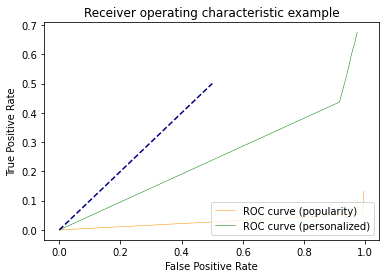

In [26]:
lw=0.5
plt.figure()
popularity_precisions, popularity_recall = zip(*popularity_data)
plt.plot([1.0 - r for r in popularity_recall], list(popularity_precisions), color='darkorange',
         lw=lw, label='ROC curve (popularity)')
personal_precisions, personal_recall= zip(*personalized_data)
plt.plot([1.0 - r for r in personal_recall], list(personal_precisions), color='green',
         lw=lw, label='ROC curve (personalized)')
plt.plot([0.0, 0.5], [0.0, 0.5], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

The curve shows that the personalized model provides much better performance, since the accuracy increased constantly as we raise the number of recommendations being made.